In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [87]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

We make usage of the core databases generated by Andrea and located in 

In [4]:
core_dbs = '/work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs'
os.listdir(core_dbs)

['12x12x3',
 '16x16x4',
 '9x9x1',
 'PW.gitlab',
 'known_hosts',
 '9x9x1_p',
 '12x12x3_p',
 '9x9x1_bkp']

# Analysis of the absorption spectrum in the equilibrium regime

We compute the equilibrium absorption spectrum in both the ip and BSE framework.

## IP analysis

The systems has 52 electrons and an equal numbers of full bands due to the SOC.

First we compute the ip absorption spectrum for various k-samplings. All the computations
are performed using the bands from 42 to 62. In this way we test the effect of the $k$-sampling
on the shape of the absorption spectra

In [5]:
run_path = 'EQ_ABS_IP'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [7]:
eta = 0.1 # damping value for both conduction and valence bands (eV) 
energy_range = [0,12] # energy range in eV
energy_step = 500 # number of energy step
elec_field = [1.,0.,0.]
bands_trans = [42,62]
scissor = 0. # 

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = os.path.join(core_dbs,k,'SAVE')
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_run_dir(source_dir,run_dir=run_dir)
    
    inp = I.YamboInput('yambo -o c',folder=run_dir)
    inp.set_array_variables(LongDrXd = elec_field,XfnQP_E=[scissor,1.,1.]) # electric field / scissor
    inp.set_array_variables(units='eV',DmRngeXd=[eta/2,eta/2],EnRngeXd=energy_range) # damping / energy range
    inp.set_array_variables(ETStpsXd =energy_step, BndsRnXd=bands_trans,QpntsRXd=[1,1]) # energy step / bands or transitions / momentum transfer
    idd = 'ip_abs-bnds_%s-%s_kpoints_%s'%(bands_trans[0],bands_trans[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

Initialize a Dataset with 1 parallel tasks
SAVE folder already present in EQ_ABS_IP/9x9x1. No operations performed.
SAVE folder already present in EQ_ABS_IP/12x12x3. No operations performed.
SAVE folder already present in EQ_ABS_IP/16x16x4. No operations performed.


In [8]:
#study.runs[0]

In [9]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of ip_abs-bnds_42-62_kpoints_9x9x1
Task [0] ended 
 
Run the task [1] 
Skip the run of ip_abs-bnds_42-62_kpoints_12x12x3
Task [1] ended 
 
Run the task [2] 
Skip the run of ip_abs-bnds_42-62_kpoints_16x16x4
Task [2] ended 
 


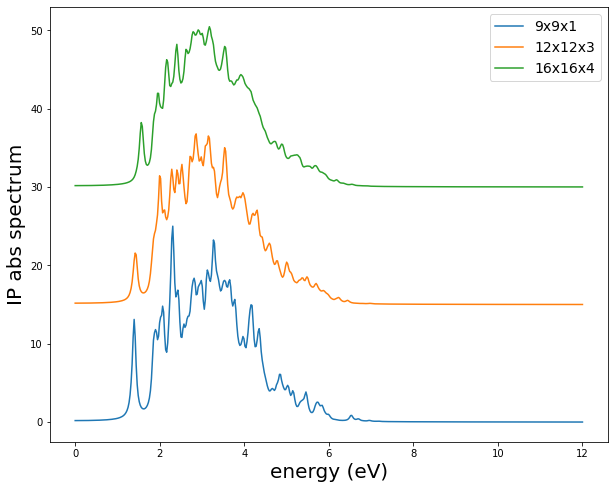

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_ip']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,15*ind+eps_im,label=k)
ax.set_ylabel('IP abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

Increasing the $k$-sampling reduces the oscillation of the spectrum as expected, but
no relevant differences are observed

Than we choose a specific $k$-sampling to perform a comparison with the experimental data. 

In this way we study the scissor, the streching and the number of bands needed to
achieve the description of the system closest to the experiment.

We compare the spectra with the experimental data for what concerns both the absorption coeffcient
$\alpha = 2\omega Im(\epsilon(\omega))/c$ and the $Im(\epsilon(\omega)$. 

In [75]:
k = kpoints[1]
print('k :',k)
run_dir = os.path.join(run_path,k)

damping = [0.07,0.07] # eV
energy_range = [0,6] # energy range in eV
energy_step = 500 # number of energy step
elec_field = [1.,0.,0.]
bands_trans = [42,62]
scissor = {'9x9x1' : 0.25, '12x12x3' : 0.18, '16x16x4' : 0.05}
XfnQP_E = {'9x9x1' :  [0.25,1.,1.], '12x12x3' : [0.18,1.,1.], '16x16x4' : [0.0,1,1.2]}
stretching = 1 # to be implemented

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -o c',folder=run_dir)
inp.set_array_variables(LongDrXd = elec_field,XfnQP_E=XfnQP_E[k]) # electric field / scissor and streching
inp.set_array_variables(units='eV',DmRngeXd=damping,EnRngeXd=energy_range) # damping / energy range
inp.set_array_variables(ETStpsXd =energy_step, BndsRnXd=bands_trans,QpntsRXd=[1,1]) # energy step / bands or transitions / momentum transfer
idd = 'ip_abs-bnds_%s-%s'%(bands_trans[0],bands_trans[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

k : 12x12x3
Initialize a Dataset with 1 parallel tasks


In [76]:
#study.runs[0]

In [77]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: EQ_ABS_IP/12x12x3/job_ip_abs-bnds_42-62.out
delete folder: EQ_ABS_IP/12x12x3/ip_abs-bnds_42-62
run command: mpirun -np 16 yambo -F ip_abs-bnds_42-62.in -J ip_abs-bnds_42-62 -C ip_abs-bnds_42-62
slurm submit:  cd EQ_ABS_IP/12x12x3 ; sbatch job_ip_abs-bnds_42-62.sh
computation ip_abs-bnds_42-62 is running...
computation ip_abs-bnds_42-62 ended
Run performed in 11s
Task [0] ended 
 


In [78]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

eps_exp = 'Experiment/BEAL_EPS2_eV.txt'
data = np.loadtxt(eps_exp).T
energy_eps,eps_exp = data

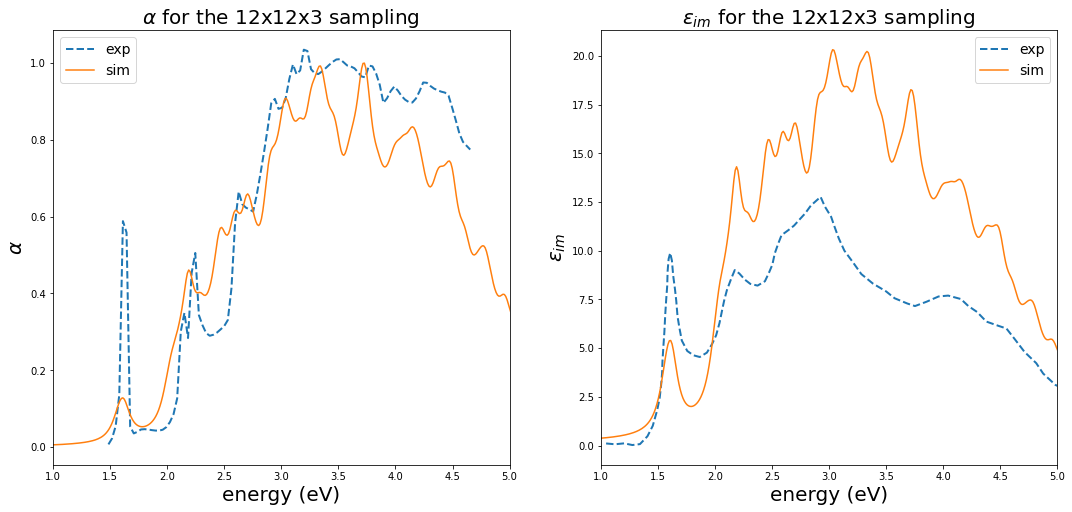

In [79]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 8))

ax[0].plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
data = results[0].data['eps_q1_ip']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
alpha = eps_im*energy
ax[0].plot(energy,alpha/max(alpha),label='sim') 
ax[0].set_xlim(1,5)
ax[0].set_ylabel(r'$\alpha$',size=20)
ax[0].set_xlabel('energy (eV)',size=20)
ax[0].set_title(r'$\alpha$ for the %s sampling'%k,size=20)
ax[0].legend(fontsize=14)

ax[1].plot(energy_eps,eps_exp,label='exp',linestyle='--',linewidth=2)

data = results[0].data['eps_q1_ip']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
ax[1].plot(energy,eps_im,label='sim') 
ax[1].set_xlim(1,5)
ax[1].set_ylabel(r'$\epsilon_{im}$',size=20)
ax[1].set_xlabel('energy (eV)',size=20)
ax[1].set_title(r'$\epsilon_{im}$ for the %s sampling'%k,size=20)
ax[1].legend(fontsize=14)

Apart from the strong reduction of the first peak, the agreement is satisfactory

## BSE Analysis

We analyze the equilibrium absorption spectrum in the BSE framework.

Also in this case we test the convergence of the spectrum w.r.t the $k$-points sampling.

### Computation of the static screening

We compute the static inverse dielectric function that is needed to compute the effective potential.

As a first step we adopt the parameters provided by the analysis performed by Andrea.

In [42]:
run_path = 'EQ_ABS_BSE'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [22]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXs = 200 # (RL) G size of the response function
NGsBlkXs_units = 'RL'
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = os.path.join(core_dbs,k,'SAVE')
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_run_dir(source_dir,run_dir=run_dir,overwrite_if_found=False,make_link=True)
    inp = I.YamboInput('yambo -X s',folder=run_dir)
    inp.set_array_variables(units=NGsBlkXs_units,NGsBlkXs=NGsBlkXs)
    inp.set_array_variables(BndsRnXs=BndsRnXs,LongDrXs=elec_field)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.4.4.2') # for 1 node on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    idd = 'em1s-ngsblkxs_%s-bndsrnxs_%s-kpoints_%s'%(NGsBlkXs,BndsRnXs[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

16 2
Initialize a Dataset with 1 parallel tasks
Create folder path EQ_ABS_BSE/9x9x1
Create a symlink of /work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs/9x9x1/SAVE in EQ_ABS_BSE/9x9x1
Executing command: cd EQ_ABS_BSE/9x9x1; yambo


In [23]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS_BSE/9x9x1',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -X s',
  'folder': 'EQ_ABS_BSE/9x9x1',
  'filename': 'yambo.in',
  'arguments': ['em1s'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'NGsBlkXs': [200, 'RL'],
   'Chimod': 'HARTREE',
   'XTermKind': 'none',
   'BndsRnXs': [[1, 100], ''],
   'LongDrXs': [[1.0, 0.0, 0.0], '']}},
 'name': 'em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1'}

In [24]:
results = study.run(selection=[0])

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1.in -J em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1 -C em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1
slurm submit:  cd EQ_ABS_BSE/9x9x1 ; sbatch job_em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1.sh
computation em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1 is running...
computation em1s-ngsblkxs_200-bndsrnxs_100_kpoints_9x9x1 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Run performed in 01m-44s
Task [0] ended 
 


## BSE calculations

In [92]:
run_path = 'EQ_ABS_BSE'
kpoints = ['9x9x1','12x12x3','16x16x4']

First we test the convergence of the spectrum w.r.t the value of the BSENGBlk variable.

We perform this analysis in the 9x9x1 sampling.

In [93]:
BSENGBlk = [50,100,150] # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = [42,62]
energy_range = [0,6] # eV
energy_step = 500
damping = [0.05,0.05] # eV
scissor = 0.35 

k = kpoints[0]
run_dir = os.path.join(run_path,k)
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
inp.set_array_variables(BSEBands=BSEBands,BLongDir=elec_field)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='RL',BSENGexx=6293)
inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
for bsengblk in BSENGBlk:
    inp.set_array_variables(units='RL',BSENGBlk=bsengblk)
    idd = 'bse-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(bsengblk,BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k])

Initialize a Dataset with 1 parallel tasks


In [97]:
#study.runs[2]

In [98]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1.in -J "bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_9x9x1" -C bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1
slurm submit:  cd EQ_ABS_BSE/9x9x1 ; sbatch job_bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1.sh
computation bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1 is running...
computation bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1 ended
Run performed in 03m-22s
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1.in -J "bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_9x9x1" -C bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1
slurm submit:  cd EQ_ABS_BSE/9x9x1 ; sbatch job_bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1.sh
computation bse-bsengblk_100-bsebands_42-62-kpoints_9x9x1 is 

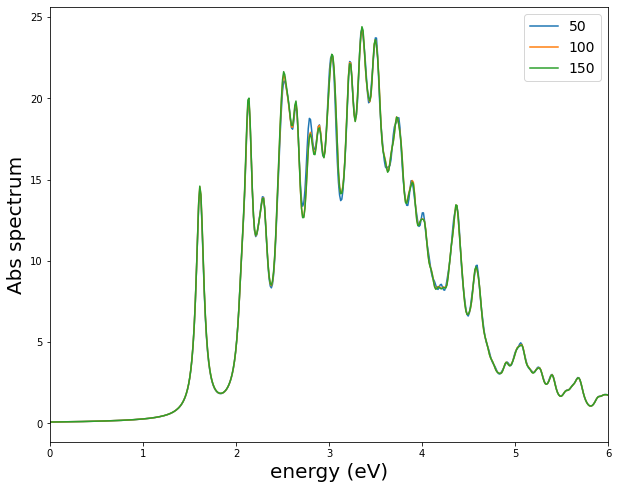

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSENGBlk):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='%s'%b) 
ax.set_xlim(0,6)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We compute the bse kernel with the BSENGBlk = 50 for all the $k$-points samplings

In [113]:
BSENGBlk = 50 #150 #200 # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = [42,62]
energy_range = [0,6] # eV
energy_step = 500
damping = [0.05,0.05] # eV
scissor = 0.35 

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = os.path.join(run_path,k)
    inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
    inp.set_array_variables(BSEBands=BSEBands,BLongDir=elec_field)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='RL',BSENGBlk=BSENGBlk,BSENGexx=6293) #,FFTGvecs=6269
    inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
    idd = 'bse-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k,'ndb_bse-bsengblk_50-bsebands_42-62'])

Initialize a Dataset with 1 parallel tasks


In [115]:
#study.runs[2]

In [116]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of bse-bsengblk_50-bsebands_42-62-kpoints_9x9x1
Task [0] ended 
 
Run the task [1] 
Skip the run of bse-bsengblk_50-bsebands_42-62-kpoints_12x12x3
Task [1] ended 
 
Run the task [2] 
delete job_out script: EQ_ABS_BSE/16x16x4/job_bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4.out
delete folder: EQ_ABS_BSE/16x16x4/bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4
run command: mpirun -np 32 yambo -F bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4.in -J "bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_16x16x4,ndb_bse" -C bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4
slurm submit:  cd EQ_ABS_BSE/16x16x4 ; sbatch job_bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4.sh
computation bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4 is running...
computation bse-bsengblk_50-bsebands_42-62-kpoints_16x16x4 ended
Run performed in 03h-56m
Task [2] ended 
 


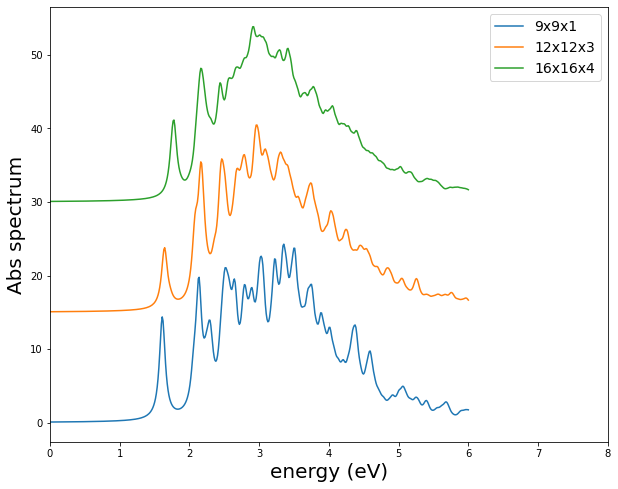

In [121]:
fig, ax = plt.subplots(figsize=(10, 8))

#ax.plot(ip_energy,ip_eps_im,label='IP',linestyle='--',linewidth=2)
for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,15*ind+eps_im,label='%s'%k) 
ax.set_xlim(0,8)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

## Comparison with experimental data

We use the kernel computed above to compare the results with the experimental data

In [118]:
run_path = 'EQ_ABS_BSE'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [134]:
k = kpoints[1]
print('k :',k)
run_dir = os.path.join(run_path,k)

BSENGBlk = 50 #150 #200 # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = [42,62]
energy_range = [0,6] # eV
energy_step = 500
damping = [0.07,0.07] # eV
KfnQP_E = {'9x9x1' :  [0.25,1.,1.], '12x12x3' : [0.31,1.,1.], '16x16x4' : [0.18,1.,1.]}

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)


inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
inp.set_array_variables(BSEBands=BSEBands,BLongDir=elec_field)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=KfnQP_E[k])
inp.set_array_variables(units='RL',BSENGBlk=BSENGBlk,BSENGexx=6293) #,FFTGvecs=6269
inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
idd = 'bse-bsengblk_%s-bsebands_%s-%s'%(BSENGBlk,BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k,'ndb_bse-bsengblk_50-bsebands_42-62'])

k : 12x12x3
Initialize a Dataset with 1 parallel tasks


In [135]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS_BSE/12x12x3',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -o b -k sex -y h',
  'folder': 'EQ_ABS_BSE/12x12x3',
  'filename': 'yambo.in',
  'arguments': ['bse', 'optics', 'bss', 'photolum'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'BSENGexx': [6293, 'RL'],
   'BSENGBlk': [50, 'RL'],
   'BEnSteps': [500, ''],
   'BSHayTrs': [-0.02, ''],
   'BSKmod': 'SEX',
   'BSEmod': 'resonant',
   'BSSmod': 'h',
   'BSEprop': 'abs',
   'BSEdips': 'none',
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[42, 62], ''],
   'BEnRange': [[0, 6], 'eV'],
   'BDmRange': [[0.07, 0.07], 'eV'],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'KfnQP_E': [[0.31, 1.0, 1.0], ''],
   'DIP_CPU': '4.4.2',
   'DIP_ROLEs': 'v.c.k',
   'BS_CPU': '8.4',
   'BS_ROLEs': 'eh.k'}},
 'jobname': ['bse-bsengblk_50-bsebands_42-62',
  'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_12x12x3',
  'ndb_bse-bsengblk_50-bseband

In [136]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of bse-bsengblk_50-bsebands_42-62
Task [0] ended 
 


In [137]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

eps_exp = 'Experiment/BEAL_EPS2_eV.txt'
data = np.loadtxt(eps_exp).T
energy_eps,eps_exp = data

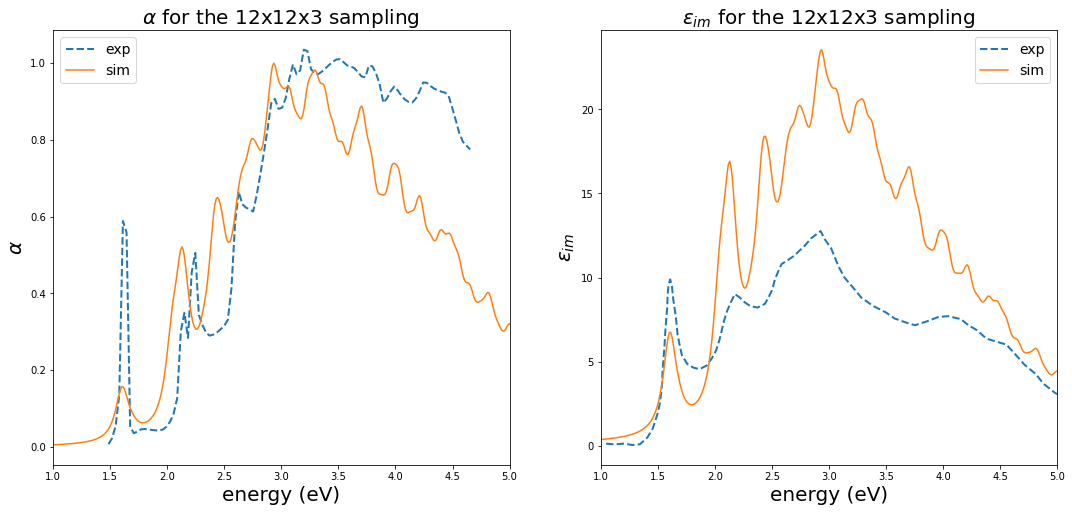

In [138]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 8))

ax[0].plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
data = results[0].data['eps_q1_haydock_bse']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
alpha = eps_im*energy
ax[0].plot(energy,alpha/max(alpha),label='sim') 
ax[0].set_xlim(1,5)
ax[0].set_ylabel(r'$\alpha$',size=20)
ax[0].set_xlabel('energy (eV)',size=20)
ax[0].set_title(r'$\alpha$ for the %s sampling'%k,size=20)
ax[0].legend(fontsize=14)

ax[1].plot(energy_eps,eps_exp,label='exp',linestyle='--',linewidth=2)

data = results[0].data['eps_q1_haydock_bse']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
ax[1].plot(energy,eps_im,label='sim') 
ax[1].set_xlim(1,5)
ax[1].set_ylabel(r'$\epsilon_{im}$',size=20)
ax[1].set_xlabel('energy (eV)',size=20)
ax[1].set_title(r'$\epsilon_{im}$ for the %s sampling'%k,size=20)
ax[1].legend(fontsize=14)

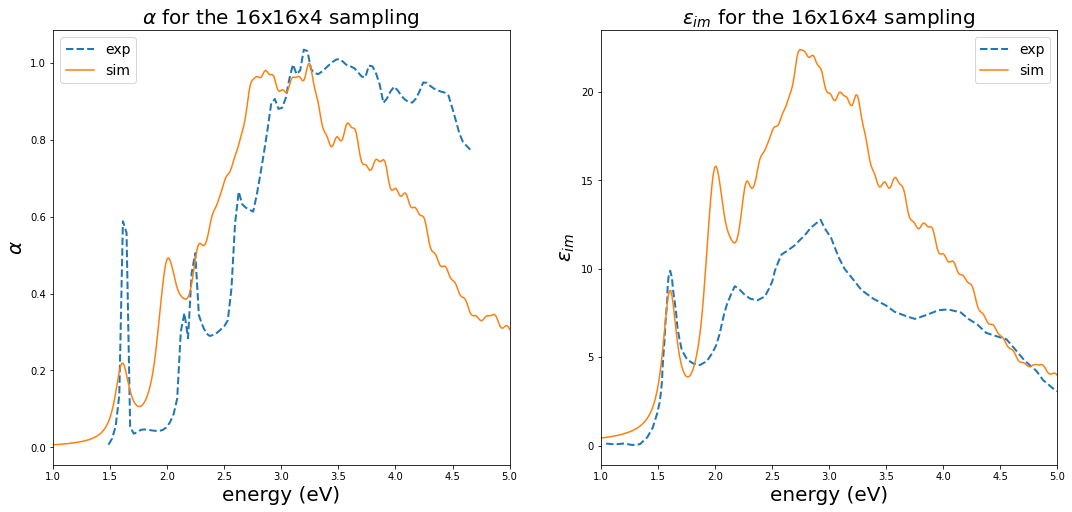

In [132]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 8))

ax[0].plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
data = results[0].data['eps_q1_haydock_bse']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
alpha = eps_im*energy
ax[0].plot(energy,alpha/max(alpha),label='sim') 
ax[0].set_xlim(1,5)
ax[0].set_ylabel(r'$\alpha$',size=20)
ax[0].set_xlabel('energy (eV)',size=20)
ax[0].set_title(r'$\alpha$ for the %s sampling'%k,size=20)
ax[0].legend(fontsize=14)

ax[1].plot(energy_eps,eps_exp,label='exp',linestyle='--',linewidth=2)

data = results[0].data['eps_q1_haydock_bse']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
ax[1].plot(energy,eps_im,label='sim') 
ax[1].set_xlim(1,5)
ax[1].set_ylabel(r'$\epsilon_{im}$',size=20)
ax[1].set_xlabel('energy (eV)',size=20)
ax[1].set_title(r'$\epsilon_{im}$ for the %s sampling'%k,size=20)
ax[1].legend(fontsize=14)

In [ ]:
#########################################################################################

Next steps : 
* compute the screening and perform the BSE for 9x9x1
* compare the abs spectrum with the experimental result
* RT analysis at the sex level. Find the linear regime by computing the number of 
  carriers in terms of the fluency of the pulse